In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/MyDrive/SIAP/dataset/clean

/content/drive/MyDrive/SIAP/dataset/clean


In [3]:
import numpy as np
import pandas as pd
import pickle as pkl
import pandas as pd
from keras.layers import Conv1D, Dense, Embedding, GlobalMaxPooling1D, Input, MaxPooling1D

from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score

from tensorflow.keras.optimizers import Adam

MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 10000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.1
BATCH_SIZE = 128
EPOCHS = 5

In [4]:
train = pd.read_csv('train_clean_removed_emoticons.csv')
sentences = train["Review Text"].fillna("DUMMY_VALUE").values
possible_labels = list(set(train["Rating"]))
y = train["Rating"].values
targets = to_categorical(y)

In [5]:
# with open("paraphrases_dict.pkl", "rb") as f:
#     object = pkl.load(f)
    
# augmented_df = pd.DataFrame(object)
# augmented_df.head()

In [6]:
paraphrases = pd.read_pickle('paraphrases_dict.pkl')
paraphrases_list = [review for batch in paraphrases.values() for review in batch]

In [7]:
# print(train[train['Review ID'] == 1214]['Review Text'] == paraphrases.get(1214)[0])

In [8]:
y_paraphrases = []
num_paraphrases = 5
for review_id in paraphrases.keys():
  rating = train[train['Review ID'] == review_id]['Rating'].values[0]
  for i in range(num_paraphrases):
    y_paraphrases.append(rating)

In [9]:
y_paraphrases = np.array(y_paraphrases)
y_paraphrases
targets_paraphrases = to_categorical(y_paraphrases)



In [10]:
new_y = np.concatenate((y_paraphrases, y), axis=0)
new_targets = to_categorical(new_y)

In [11]:
possible_labels = list(set(new_y))
possible_labels

[1, 2, 3, 4, 5]

In [12]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
#ps = LancasterStemmer()
ps = PorterStemmer()

tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.add('dress')
stop_words.add('petite')
stop_words.add('jacket')
stop_words.add('blazer')

def preprocessing(data):
    txt = data.str.lower().str.cat(sep=' ') #1
    words = tokenizer.tokenize(txt) #2
    words = [w for w in words if not w in stop_words] #3
    #words = [ps.stem(w) for w in words] #4 steming kad ubacimo daje losije rezultate
    return words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
import re
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
    #text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
train['Cleaned_Review_Text'] = train['Review Text'].apply(clean_text)

paraphrases_train = []
for sentence in paraphrases_list:
  paraphrases_train.append(clean_text(sentence))



In [14]:
new_str = [str(x) for x in train['Cleaned_Review_Text']]

df = pd.DataFrame(new_str)
temp = []
for i in range(len(df)):
  temp.append(preprocessing(df.iloc[i]))


paraphrases_df = pd.DataFrame(paraphrases_train)
paraphrases_temp = []
for i in range(len(paraphrases_df)):
  paraphrases_temp.append(preprocessing(paraphrases_df.iloc[i]))


new_temp = paraphrases_temp + temp
# print(len(new_temp))



In [15]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(new_temp)
sequences = tokenizer.texts_to_sequences(new_temp)
s = sorted(len(s) for s in sequences)
word2idx = tokenizer.word_index

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
#print("Shape of data tensor:", data.shape)

num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)

In [16]:
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    input_length=MAX_SEQUENCE_LENGTH,
)

In [17]:
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
# --------------------------------------
x = Conv1D(256, 3, activation="relu")(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation="relu")(x)
# x = MaxPooling1D(3)(x)
# x = Conv1D(128, 3, activation="relu")(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation="relu")(x)
output = Dense(len(possible_labels) + 1, activation="softmax")(x)

model = Model(input_, output)
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.01),
    metrics=["accuracy"],
)

In [18]:
r = model.fit(
    data,
    new_targets,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
)

Epoch 1/5
412/412 [==============================] - 11s 21ms/step - loss: 1.0749 - accuracy: 0.5506 - val_loss: 1.0418 - val_accuracy: 0.5567
Epoch 2/5
412/412 [==============================] - 8s 18ms/step - loss: 0.7568 - accuracy: 0.6971 - val_loss: 1.1239 - val_accuracy: 0.5536
Epoch 3/5
412/412 [==============================] - 7s 18ms/step - loss: 0.5623 - accuracy: 0.7828 - val_loss: 1.1904 - val_accuracy: 0.6041
Epoch 4/5
412/412 [==============================] - 7s 18ms/step - loss: 0.4230 - accuracy: 0.8389 - val_loss: 0.9689 - val_accuracy: 0.6537
Epoch 5/5
412/412 [==============================] - 8s 18ms/step - loss: 0.3481 - accuracy: 0.8720 - val_loss: 1.3365 - val_accuracy: 0.5993


In [19]:
p = model.predict(data)
y_pred = []
for prediction in p:
    y_pred.append(np.argmax(prediction, axis=0))

In [20]:
print(confusion_matrix(new_y, y_pred))

[[ 3494   273    83    82    10]
 [  230  6549   468   157    18]
 [   51   730 11769   905   101]
 [   32    53   434 22724   262]
 [   65   100   267  2652  6954]]


In [21]:
print(classification_report(new_y, y_pred))

              precision    recall  f1-score   support

           1       0.90      0.89      0.89      3942
           2       0.85      0.88      0.87      7422
           3       0.90      0.87      0.89     13556
           4       0.86      0.97      0.91     23505
           5       0.95      0.69      0.80     10038

    accuracy                           0.88     58463
   macro avg       0.89      0.86      0.87     58463
weighted avg       0.89      0.88      0.88     58463



In [22]:
print(f1_score(new_y, y_pred, average="micro"))

0.880727981800455


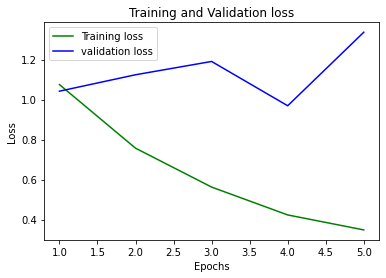

In [23]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

loss_train = r.history['loss']
loss_val = r.history['val_loss']
epochs = range(1,6)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Test**

In [24]:
test = pd.read_csv('validation_clean_removed_emoticons.csv')
test_text = test["Review Text"].values
test_text = [str(x).lower() for x in test_text]

sequences = tokenizer.texts_to_sequences(test_text)
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

y_test = test["Rating"].values

In [25]:
p = model.predict(data)
y_pred = []
for prediction in p:
    y_pred.append(np.argmax(prediction, axis=0))

In [26]:
print(confusion_matrix(y_test, y_pred))

[[ 15  24  18  18   7]
 [ 13  50  47  33  14]
 [ 11  52  89  98  32]
 [ 16  29  65 264 121]
 [ 20  20  69 542 595]]


In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.20      0.18      0.19        82
           2       0.29      0.32      0.30       157
           3       0.31      0.32      0.31       282
           4       0.28      0.53      0.36       495
           5       0.77      0.48      0.59      1246

    accuracy                           0.45      2262
   macro avg       0.37      0.37      0.35      2262
weighted avg       0.55      0.45      0.47      2262



In [28]:
print(f1_score(y_test, y_pred, average="micro"))

0.4478337754199823


In [29]:
# model.save("cnn_augmented_0.604")